# Домашнее задание: Полиномиальная регрессия

## 1. Загрузка данных и предварительный анализ

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import joblib

# Загрузка данных
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Определение целевой переменной
target_col = "Premium Amount"

# Разделение на признаки и целевую переменную
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

# Удаляем целевую переменную, если она есть в test.csv
X_test = test_df.drop(columns=[target_col], errors='ignore')

# Проверка структуры данных
print("Train dataset info:")
print(train_df.info())

print("\nTest dataset info:")
print(test_df.info())


Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1000 non-null   int64  
 1   Age                   985 non-null    float64
 2   Gender                1000 non-null   object 
 3   Annual Income         957 non-null    float64
 4   Marital Status        982 non-null    object 
 5   Number of Dependents  911 non-null    float64
 6   Education Level       1000 non-null   object 
 7   Occupation            681 non-null    object 
 8   Health Score          939 non-null    float64
 9   Location              1000 non-null   object 
 10  Policy Type           1000 non-null   object 
 11  Previous Claims       687 non-null    float64
 12  Vehicle Age           1000 non-null   float64
 13  Credit Score          876 non-null    float64
 14  Insurance Duration    1000 non-null   float64
 15  Po

## 2. EDA (Исследовательский анализ данных)

Доля пропусков в train dataset:
Age                      1.5
Annual Income            4.3
Marital Status           1.8
Number of Dependents     8.9
Occupation              31.9
Health Score             6.1
Previous Claims         31.3
Credit Score            12.4
Customer Feedback        6.8
dtype: float64

Статистика по числовым признакам:
                 id         Age  Annual Income  Number of Dependents  \
count  1.000000e+03  985.000000     957.000000            911.000000   
mean   6.089995e+05   41.021320   33337.207941              2.013172   
std    3.557500e+05   13.664927   31979.621769              1.383514   
min    4.765000e+03   18.000000      20.000000              0.000000   
10%    1.188940e+05   22.000000    2590.000000              0.000000   
25%    2.965805e+05   29.000000    7135.000000              1.000000   
50%    5.940075e+05   41.000000   25720.000000              2.000000   
75%    9.258905e+05   53.000000   45636.000000              3.000000   
90%    1.

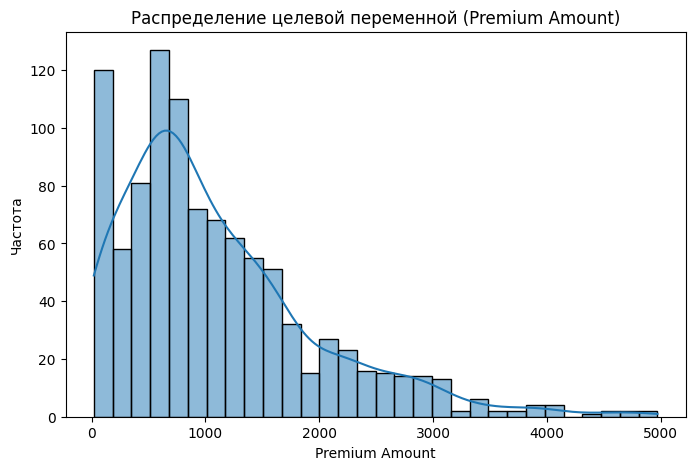

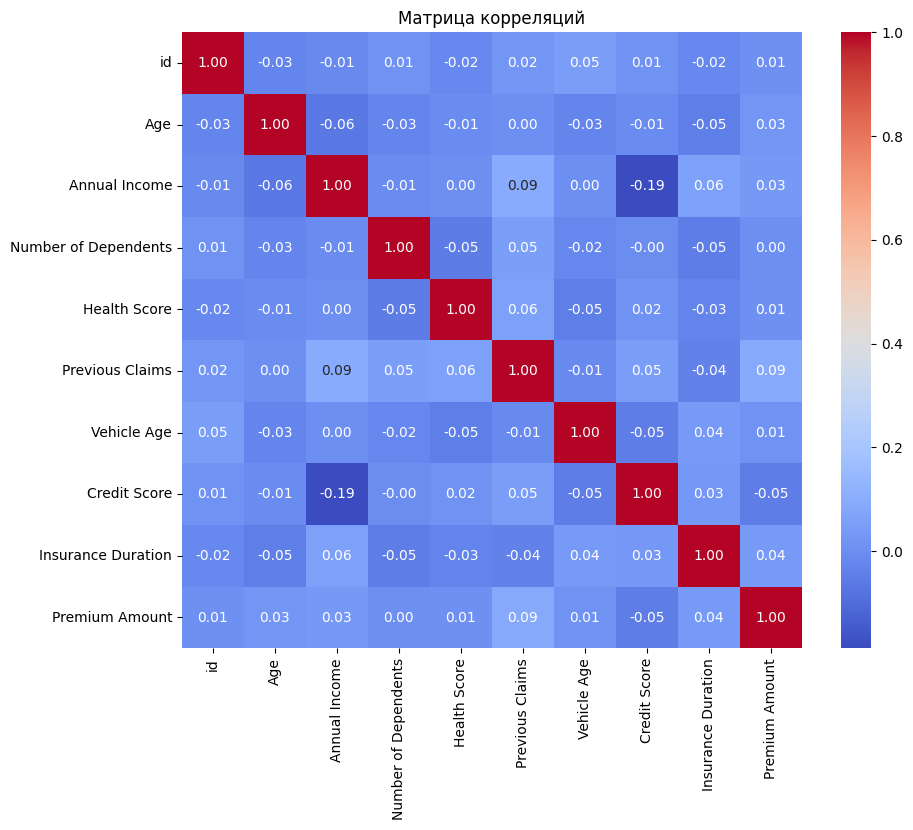

In [2]:

# Доля пропусков
missing_values = train_df.isnull().sum() / len(train_df) * 100
print("Доля пропусков в train dataset:")
print(missing_values[missing_values > 0])

# Статистические характеристики
print("\nСтатистика по числовым признакам:")
print(train_df.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))

# Визуализация целевой переменной
plt.figure(figsize=(8, 5))
sns.histplot(y_train, bins=30, kde=True)
plt.title("Распределение целевой переменной (Premium Amount)")
plt.xlabel(target_col)
plt.ylabel("Частота")
plt.show()

# Исправление: Оставляем только числовые признаки перед корреляцией
numeric_df = train_df.select_dtypes(include=[np.number])

# Матрица корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций")
plt.show()


## 3. Подготовка данных

In [3]:

# Определяем числовые и категориальные признаки
numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns

# Создаем трансформеры для обработки
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Заполняем NaN медианой
    ("scaler", StandardScaler())  # Масштабируем числовые признаки
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))  # Кодируем категориальные признаки
])

# Объединяем в `ColumnTransformer`
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Применяем преобразования
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Предобработка данных завершена.")


Предобработка данных завершена.


## 4. Обучение моделей

In [4]:

# Обучение линейной регрессии
linear_model = LinearRegression()
linear_model.fit(X_train_processed, y_train)

# Предсказание
y_train_pred_linear = linear_model.predict(X_train_processed)

# Оценка качества модели
mae_linear = mean_absolute_error(y_train, y_train_pred_linear)
mse_linear = mean_squared_error(y_train, y_train_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_train, y_train_pred_linear)

print("Линейная регрессия:")
print(f"MAE: {mae_linear:.4f}")
print(f"MSE: {mse_linear:.4f}")
print(f"RMSE: {rmse_linear:.4f}")
print(f"R^2: {r2_linear:.4f}")


Линейная регрессия:
MAE: 0.0682
MSE: 0.0119
RMSE: 0.1091
R^2: 1.0000


## 5. Полиномиальная регрессия

In [5]:

# Полиномиальная регрессия (degree=2, только взаимодействия)
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_poly = poly.fit_transform(X_train_processed)
X_test_poly = poly.transform(X_test_processed)

# Используем Ridge вместо LinearRegression
poly_model = Ridge(alpha=1.0)
poly_model.fit(X_train_poly, y_train)

# Предсказание
y_train_pred_poly = poly_model.predict(X_train_poly)

# Оценка качества модели
mae_poly = mean_absolute_error(y_train, y_train_pred_poly)
mse_poly = mean_squared_error(y_train, y_train_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_train, y_train_pred_poly)

print("Полиномиальная регрессия:")
print(f"MAE: {mae_poly:.4f}")
print(f"MSE: {mse_poly:.4f}")
print(f"RMSE: {rmse_poly:.4f}")
print(f"R^2: {r2_poly:.4f}")


Полиномиальная регрессия:
MAE: 24.0786
MSE: 987.2143
RMSE: 31.4200
R^2: 0.9987


## 6. Кросс-валидация полиномиальной регрессии

In [6]:

# Кросс-валидация
cross_val_scores = cross_val_score(poly_model, X_train_poly, y_train, cv=5, scoring="r2")

# Средний R^2
print("Средний R^2 по кросс-валидации:", np.mean(cross_val_scores))


Средний R^2 по кросс-валидации: -0.6567337644323443


## 7. Сохранение модели и предсказаний

In [7]:

# Сохранение модели
joblib.dump(poly_model, "ridge_poly_model.joblib")

# Предсказание на тесте
y_test_pred = poly_model.predict(X_test_poly)

# Сохранение предсказаний
test_predictions = pd.DataFrame({"Prediction": y_test_pred})
test_predictions.to_csv("test_predictions.csv", index=False)
print("Предсказания сохранены в 'test_predictions.csv'")


Предсказания сохранены в 'test_predictions.csv'
